In [2]:
import pandas as pd 

In [3]:
import os 
pwd = r'X:\Datasets\Blockchain\xblock.pro\eth-phishing-detection\original_data\open'

In [4]:
import networkx as nx 

gs = []

for file in os.listdir(pwd + "/钓鱼一阶节点/"):
    if file.endswith(".csv"):
        df = pd.read_csv(pwd + "/钓鱼一阶节点/" + file)
        G = nx.MultiDiGraph()

        for index, row in df.iterrows():
            fromx = row['From']
            tox = row['To']
            value = row['Value']
            print(fromx, tox, value)
            G.add_edge(fromx, tox, weight=value)
        
        gs.append(G)

0xd551234ae421e3bcba99a0da6d736074f22192ff 0x002bf459dc58584d58886169ea0e80f3ca95ffaf 0.58626948
0x002bf459dc58584d58886169ea0e80f3ca95ffaf 0x6ab5cb8793bef44a90ba8beb6d966850cd5dab29 0.58540848
0xd551234ae421e3bcba99a0da6d736074f22192ff 0x002bf459dc58584d58886169ea0e80f3ca95ffaf 0.94751513
0x002bf459dc58584d58886169ea0e80f3ca95ffaf 0xfb03e59c83b984da0f6a5575b955541af28ccc65 0.94728413
0x16f209b5332a1b4fa5bf19497ca40154c5db2f85 0x002f0c8119c16d310342d869ca8bf6ace34d9c39 0.5
0xe7e07e44ee315b5f2d076340b2b7a5cc9a4ee57b 0x002f0c8119c16d310342d869ca8bf6ace34d9c39 0.00102
0x002f0c8119c16d310342d869ca8bf6ace34d9c39 0xe892875b87b94c44edf0e91ee9f49d0525fadd83 0.50039
0x0681d8db095565fe8a346fa0277bffde9c0edbbf 0x002f0c8119c16d310342d869ca8bf6ace34d9c39 0.8178
0x002f0c8119c16d310342d869ca8bf6ace34d9c39 0xe892875b87b94c44edf0e91ee9f49d0525fadd83 0.817506
0x97425ba35ffcbe298007684d8b8ecf0053895055 0x0059b14e35dab1b4eee1e2926c7a5660da66f747 0.45001719
0xd316b4460508e9a52c865c6bff1e4687891ed9a5 0x0059

In [5]:
def extract_graphlets(graphs):
    motifs = {
    'motif1': nx.DiGraph([(0, 1), (1, 2)]),
    'motif2': nx.DiGraph([(0, 1), (2, 1)]),
    'motif3': nx.DiGraph([(0, 1), (0, 2)]),
    }

    # 提取motifs特征
    f = {}

    # 从node_graphs中提取motifs特征, 统计motifs的数量

    for motif in motifs:
        for subgraph in nx.algorithms.isomorphism.GraphMatcher(graphs, motifs[motif]).subgraph_isomorphisms_iter():
            # motif_features[motif] += 1
            # print(motif, subgraph)

            node0_addr = list(subgraph.keys())[0]
            node1_addr = list(subgraph.keys())[1]
            node2_addr = list(subgraph.keys())[2]
            # print(node0_addr, node1_addr, node2_addr)
            
            if motif == 'motif1':
                value1 = graphs[node0_addr][node1_addr][0]['weight']
                value2 = graphs[node1_addr][node2_addr][0]['weight']
            elif motif == 'motif2':
                value1 = graphs[node0_addr][node1_addr][0]['weight']
                value2 = graphs[node2_addr][node1_addr][0]['weight']
                if value1 > value2:
                    value1, value2 = value2, value1
            elif motif == 'motif3':
                value1 = graphs[node0_addr][node1_addr][0]['weight']
                value2 = graphs[node0_addr][node2_addr][0]['weight']
                if value1 > value2:
                    value1, value2 = value2, value1

            key = motif + '_' + str(value1) + '_' + str(value2)
            f[key] = f.get(key, 0) + 1
    
    return f

In [6]:
features = {}

index = 0
length = len(gs)

for g in gs:
    index += 1
    print("Process: {}/{}".format(index, length), end='\r')
    f = extract_graphlets(g)
    for key in f:
        features[key] = features.get(key, 0) + f[key]

In [7]:
# 转化为DataFrame
df = pd.DataFrame.from_dict(features, orient='index', columns=['count'])
df = df.sort_values(by='count', ascending=False)

In [8]:
# 将index转化为列
df['index'] = df.index

In [9]:
# 重新设置index
df = df.reset_index(drop=True)
df

count                         index
0        121690          motif2_0.0001_0.0001
1         96596          motif2_0.0001_0.0005
2         50166           motif2_0.0001_0.001
3         26384                motif2_0.5_1.0
4         21052                motif2_0.5_0.5
...         ...                           ...
1075481       1       motif1_1.071_0.14099763
1075482       1       motif1_1.071_0.25192242
1075483       1       motif1_1.071_0.09940604
1075484       1       motif1_1.071_2.21412314
1075485       1  motif1_0.58626948_0.58540848

[1075486 rows x 2 columns]

In [10]:
df['ratio'] = df['count'] / df['count'].sum()

In [11]:
# 获取motifs1的特征
df[df['index'].str.contains('motif1')].head(20)

count            index     ratio
155   1111   motif1_0.1_1.0  0.000280
277    597   motif1_1.0_1.0  0.000150
367    423   motif1_0.2_1.0  0.000107
372    416  motif1_1.0_0.01  0.000105
394    396   motif1_0.5_1.0  0.000100
446    341  motif1_0.1_10.0  0.000086
459    336   motif1_0.1_2.0  0.000085
465    329   motif1_0.1_0.5  0.000083
508    299  motif1_0.1_0.01  0.000075
565    272   motif1_0.1_0.1  0.000068
641    250   motif1_0.5_0.1  0.000063
648    247   motif1_0.5_7.0  0.000062
700    228  motif1_0.1_1.05  0.000057
788    204   motif1_1.0_0.1  0.000051
796    202   motif1_0.3_1.0  0.000051
805    202   motif1_0.5_0.5  0.000051
828    197   motif1_0.2_0.1  0.000050
841    191   motif1_0.1_0.2  0.000048
845    190   motif1_0.1_5.0  0.000048
855    187  motif1_0.2_0.01  0.000047

In [12]:
# 获取motifs2的特征
df[df['index'].str.contains('motif2')].head(20)

count                 index     ratio
0   121690  motif2_0.0001_0.0001  0.030639
1    96596  motif2_0.0001_0.0005  0.024321
2    50166   motif2_0.0001_0.001  0.012631
3    26384        motif2_0.5_1.0  0.006643
4    21052        motif2_0.5_0.5  0.005300
5    19834   motif2_0.0005_0.001  0.004994
6    19250        motif2_1.0_1.0  0.004847
7    18970  motif2_0.0005_0.0005  0.004776
8    18234   motif2_0.0001_0.005  0.004591
9    16770  motif2_0.0083_0.0083  0.004222
10   15288        motif2_0.1_1.0  0.003849
11   13092        motif2_1.0_2.0  0.003296
12   11936    motif2_0.002_0.002  0.003005
13   11476   motif2_0.0001_0.002  0.002889
14   11390        motif2_0.2_1.0  0.002868
15   11194        motif2_0.2_0.5  0.002818
16   10938    motif2_0.0001_0.01  0.002754
17   10932        motif2_0.1_0.1  0.002752
18   10284        motif2_0.1_0.5  0.002589
19    9926        motif2_0.5_2.0  0.002499

In [13]:
# 获取motifs3的特征
df[df['index'].str.contains('motif3')].head(20)

count                 index     ratio
40    4270      motif3_0.01_0.01  0.001075
64    2894        motif3_0.3_0.3  0.000729
76    2596    motif3_0.001_0.001  0.000654
88    2042   motif3_0.0008_0.001  0.000514
103   1638        motif3_0.3_0.4  0.000412
113   1506    motif3_0.001_0.002  0.000379
131   1300        motif3_6.6_6.7  0.000327
147   1144        motif3_6.7_7.0  0.000288
157   1100        motif3_6.6_7.0  0.000277
190    848   motif3_0.0005_0.001  0.000214
202    780        motif3_6.7_7.1  0.000196
203    774    motif3_0.002_0.002  0.000195
211    756  motif3_0.0008_0.0008  0.000190
213    750        motif3_6.6_7.1  0.000189
218    734    motif3_0.001_0.003  0.000185
222    730     motif3_0.002_0.01  0.000184
248    680    motif3_0.002_0.003  0.000171
253    666        motif3_7.0_7.0  0.000168
256    660        motif3_7.0_7.1  0.000166
258    650        motif3_6.7_6.7  0.000164

In [14]:
df.head(20)

count                 index     ratio
0   121690  motif2_0.0001_0.0001  0.030639
1    96596  motif2_0.0001_0.0005  0.024321
2    50166   motif2_0.0001_0.001  0.012631
3    26384        motif2_0.5_1.0  0.006643
4    21052        motif2_0.5_0.5  0.005300
5    19834   motif2_0.0005_0.001  0.004994
6    19250        motif2_1.0_1.0  0.004847
7    18970  motif2_0.0005_0.0005  0.004776
8    18234   motif2_0.0001_0.005  0.004591
9    16770  motif2_0.0083_0.0083  0.004222
10   15288        motif2_0.1_1.0  0.003849
11   13092        motif2_1.0_2.0  0.003296
12   11936    motif2_0.002_0.002  0.003005
13   11476   motif2_0.0001_0.002  0.002889
14   11390        motif2_0.2_1.0  0.002868
15   11194        motif2_0.2_0.5  0.002818
16   10938    motif2_0.0001_0.01  0.002754
17   10932        motif2_0.1_0.1  0.002752
18   10284        motif2_0.1_0.5  0.002589
19    9926        motif2_0.5_2.0  0.002499

In [15]:
count1 = df[df['index'].str.contains('motif1')]['count'].sum()
count2 = df[df['index'].str.contains('motif2')]['count'].sum()
count3 = df[df['index'].str.contains('motif3')]['count'].sum()

print("ratio1: ", count1 / (count1 + count2 + count3))
print("ratio2: ", count2 / (count1 + count2 + count3))
print("ratio3: ", count3 / (count1 + count2 + count3))

ratio1:  0.12389549870559272
ratio2:  0.7566514305453934
ratio3:  0.1194530707490139


In [16]:
df3 = df[df['index'].str.contains('motif3')]
df3.head()

count                index     ratio
40    4270     motif3_0.01_0.01  0.001075
64    2894       motif3_0.3_0.3  0.000729
76    2596   motif3_0.001_0.001  0.000654
88    2042  motif3_0.0008_0.001  0.000514
103   1638       motif3_0.3_0.4  0.000412

In [17]:
df3['value1'] = df3['index'].str.split('_').str[1].astype(float)
df3['value2'] = df3['index'].str.split('_').str[2].astype(float)


c:\Users\YangXikang\Tools\Anaconda3\envs\blockchain-crawler\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\Users\YangXikang\Tools\Anaconda3\envs\blockchain-crawler\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
mean_value1 = df3['value1'].mean()
mean_value2 = df3['value2'].mean()

print("mean_value1: ", mean_value1)
print("mean_value2: ", mean_value2)
print("mean_value: ", (mean_value1 + mean_value2) / 2)

mean_value1:  0.43710436145110626
mean_value2:  4.152483566760897
mean_value:  2.2947939641060016


[1e-18, 0.0003, 0.0013, 0.0048747656003407, 0.009, 0.0149037, 0.0253948905480217, 0.03667828, 0.04337295, 0.04951991, 0.05473112, 0.05748451, 0.06, 0.06473174, 0.0668369, 0.0708244, 0.07358172, 0.07823176, 0.08228779, 0.08702727, 0.0911942, 0.09374657, 0.099, 0.10050518, 0.10261668, 0.10574115, 0.1106736, 0.11223858, 0.11392011, 0.11912493, 0.12, 0.1224484, 0.12500152, 0.13, 0.13381996, 0.13849106, 0.14114884, 0.14551927, 0.14963439, 0.15358274, 0.16, 0.16600816, 0.17182302, 0.17934695, 0.18492969, 0.18968913, 0.19707683, 0.2, 0.20359468, 0.21507369, 0.22117371, 0.22780184, 0.23561273720000567, 0.24684417, 0.26001849, 0.27077, 0.28465189, 0.29748724, 0.3034585, 0.31359223, 0.31659123, 0.33763081, 0.3645839, 0.40184911, 0.41229502, 0.42585767, 0.45111799, 0.47540926, 0.49368834, 0.51653269, 0.54370796, 0.5973138, 0.62300178, 0.67258865, 0.69952668, 0.75065726, 0.78428769, 0.82927027, 0.91050411, 0.9879673, 1.00112595, 1.01425894, 1.05129576, 1.11468619, 1.2, 1.34135493, 1.47246892, 1.73

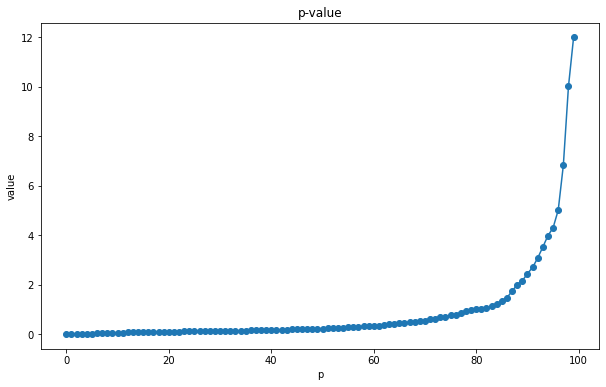

In [31]:
motif3_values = df3['value1'].tolist() + df3['value2'].tolist()

# dataframe 
mvdf = pd.DataFrame(motif3_values, columns=['value'])

# 计算p50-p99, 每0.01为一个区间
pvalue = []

for i in range(0, 100):
    pvalue.append(mvdf['value'].quantile(i / 100))

print(pvalue)
# 绘图pvalue
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(pvalue, marker='o')
plt.xlabel('p')
plt.ylabel('value')
plt.title('p-value')
plt.show()

In [176]:
max(motif3_values)

25533.6145177584